DOGE static vs dynamic

In [115]:
import numpy as np
import pandas as pd
import yfinance as yf
from numpy.ma.core import resize
from scipy.stats import t
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
import pyextremes as pyx
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm

In [116]:
def get_doge_data():
    doge_yf = yf.download("DOGE-USD", start="2014-01-01", interval="1d")
    print(doge_yf)

    doge_data = pd.read_csv("doge_data.csv")
    doge_data['Date'] = pd.to_datetime(doge_data['Timestamp'])
    print(doge_data)

    result_dataset = pd.DataFrame()
    for i in range(0, len(doge_data)):
        # print(doge_data.iloc[i])
        if (doge_data.iloc[i]['Date'] < pd.to_datetime('2017-11-09 00:00:00.000')):
            new_entry = {'Date': doge_data.iloc[i]['Date'], 'Price': doge_data.iloc[i]['Price']}
            result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    doge_yf = doge_yf.reset_index()

    # Now select only the 'Date' and 'Close' columns
    doge_date_close = doge_yf[['Date', 'Close']]
    doge_date_close.columns = doge_date_close.columns.droplevel(level=1)
    print(doge_date_close.head())

    for i in range(0, len(doge_date_close)):
        new_entry = {'Date': doge_date_close.iloc[i]['Date'], 'Price': doge_date_close.iloc[i]['Close']}
        # print(new_entry)
        result_dataset = pd.concat([result_dataset, pd.DataFrame([new_entry])], ignore_index=True)

    current = pd.to_datetime('2013-12-15 00:00:00.00')
    cnt = 0
    print(len(result_dataset))
    for i in range(0, len(result_dataset)):
        if (result_dataset.iloc[i]['Date'] != current):
            cnt += 1
            i -= 1
            print(current)
        current = current + pd.Timedelta(days=1)
    print(cnt)
    result_dataset.to_csv('doge_daily_data.csv', index=False)
    print(result_dataset)

#get_doge_data()

### EVT-Based VaR & ES Estimation with Threshold Diagnostics

This section prepares Dogecoin daily return data and defines key functions for estimating tail risk using **Extreme Value Theory (EVT)** via the **Peaks Over Threshold (POT)** method.

---

#### Data Preparation

- Loads daily Dogecoin prices from `doge_daily_data.csv`.
- Plots the price time series.
- Computes and plots **log returns**, which are used as input to EVT models.

---

#### Threshold Selection Tools

- **`hill_estimator(data, k)`**  
  Estimates the tail index `ξ` using the **Hill estimator** for the top `k` order statistics.

- **`pickands_estimator(data, k)`**  
  Computes the **Pickands estimator** for `ξ`, using log-ratios of spacings in the top order statistics.

- **`threshold_picking(data0)`**  
  Visual tool for threshold selection:
  - Uses the **Mean Residual Life (MRL)** plot to identify linear regions.
  - Plots **Hill** and **Pickands** estimates vs. `k` to assess tail stability.
  - Adds a **parameter stability plot** to assess robustness of GPD shape and scale estimates over threshold choices.
  - outputs sorted data

---

#### EVT Tail Fitting and Risk Metrics

- **`modeling(data0, u)`**  
  Fits a **Generalized Pareto Distribution (GPD)** to the exceedances over threshold `u`:
  - Applies POT to the **left tail** (i.e., large losses),
  - Returns GPD parameters: shape `ξ` and scale `σ`.

- **`prediction(params, data, u, level)`**  
  Calculates **Value at Risk (VaR)** and **Expected Shortfall (ES)** at confidence level `α`:
  - Uses analytical formulae based on the GPD,
  - Returns **VaR and ES values**


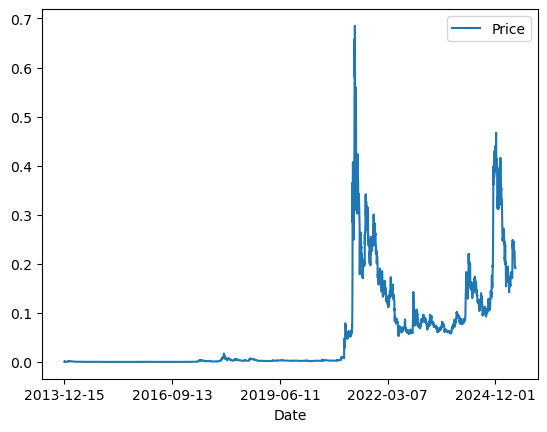

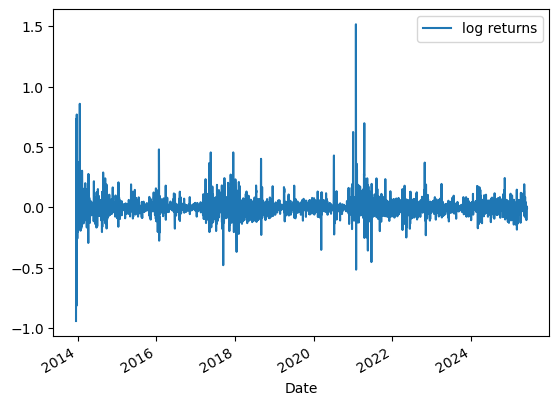

In [117]:
# functions

doge_data = pd.read_csv("../data/doge_daily_data.csv")
doge_data.set_index("Date", inplace=True)
doge_data.plot(label="Doge Price")
plt.legend()

log_doge_returns = np.log(doge_data / doge_data.shift(1)).dropna()
log_doge_returns = log_doge_returns['Price']
log_doge_returns.index = pd.to_datetime(log_doge_returns.index)
plt.figure()
log_doge_returns.plot(label="log returns")
plt.legend()


def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]
    pyx.plot_mean_residual_life(data)

    # Mean residual life plot plots average excess value over given threshold for a series of thresholds.
    # The idea is that the mean residual life plot should be approximately linear above a threshold for    
    # which the Generalized Pareto Distribution model is valid.

    datas = np.sort(data)[::-1]
    k_values = range(4, len(datas)//2)

    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, hill_estimates, 'b-')
    plt.xlabel("k_values")
    plt.ylabel("hill estimates")

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    plt.xlabel("k_values")
    plt.ylabel("pickands' estimates")

    # Parameter stability plot shows how shape and modified scale parameters of the Generalized
    # Pareto Distribution change over a range of threshold values. The idea is that these parameters
    # should be stable (vary by small amount) within a range of valid thresholds.

    pyx.plot_parameter_stability(log_doge_returns)
    plt.title("Parameter stability plot")
    plt.show()
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = pyx.EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total # probability of exceeding the threshold u
    print("Violation ratio: ", F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)
    ES = ES = (VaR + (sig - xi * u)/xi) / (1 - xi)
    return -VaR, -ES

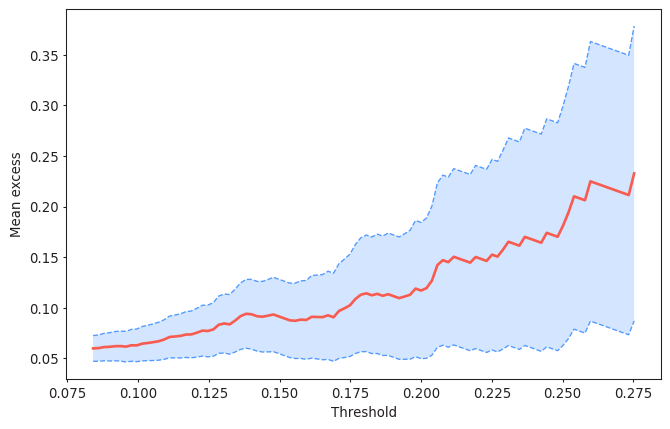

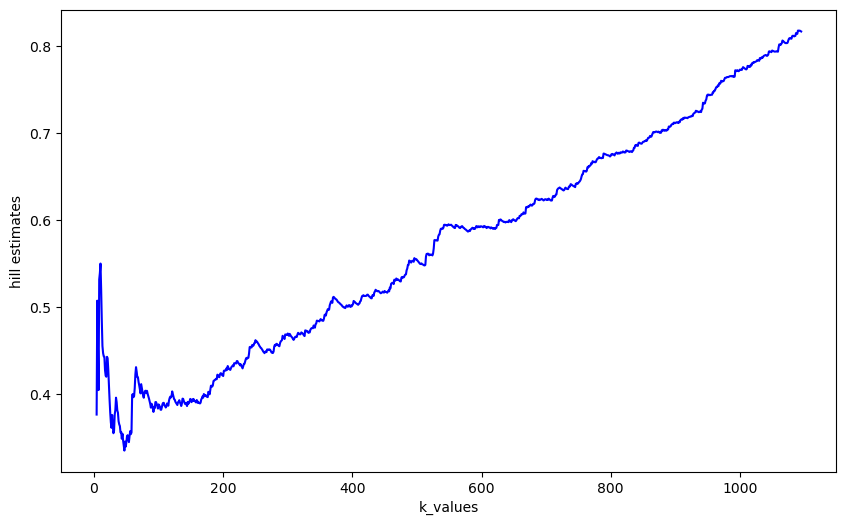

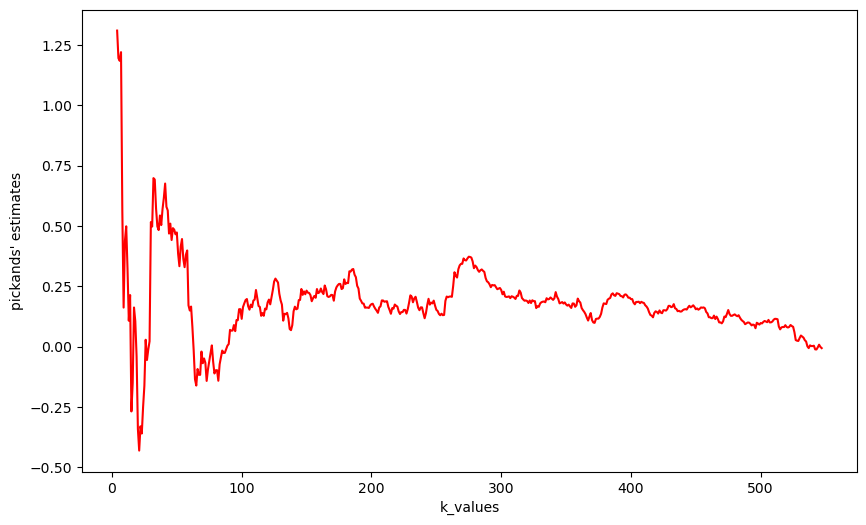

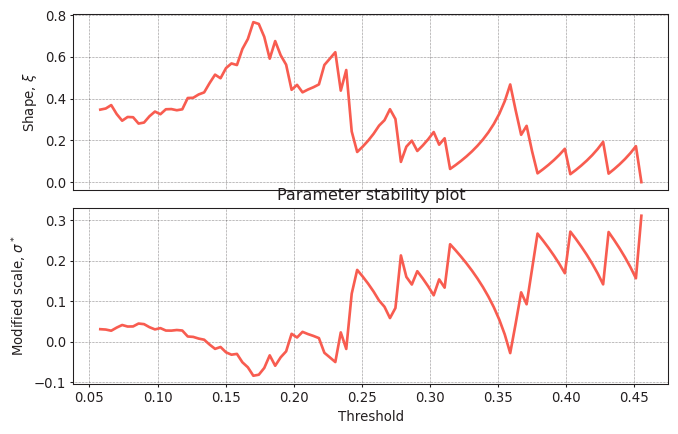

In [118]:
sorted_static_doge = threshold_picking(log_doge_returns)

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

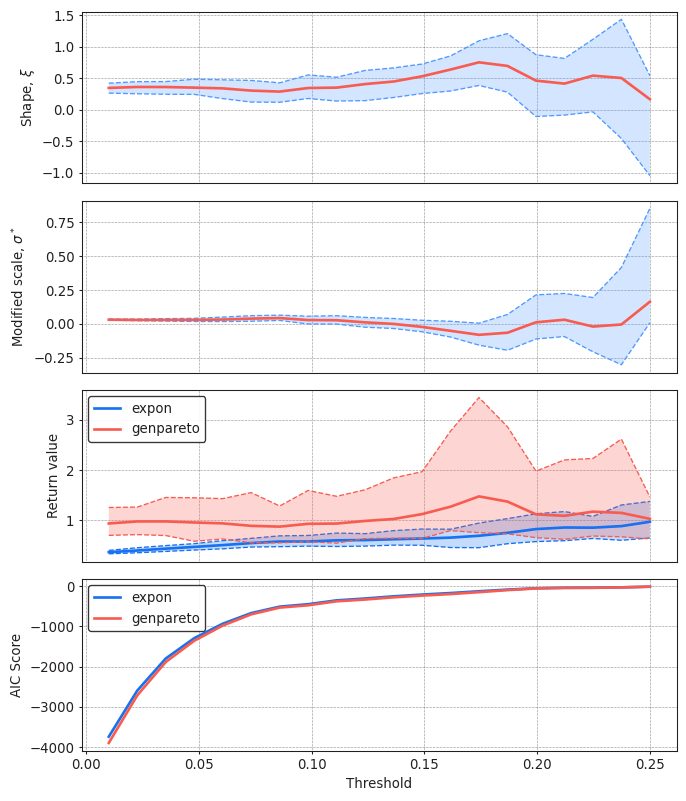

In [119]:
pyx.plot_threshold_stability(log_doge_returns, return_period=10, alpha=0.95, thresholds=np.linspace(0.01, 0.25, 20))
#u = 0.02

# pyextremes provides a convenience function to put all of the above together. It also adds an
# additional plot - AIC curve indicating relative model performance. The AIC curve should not
# be used as a threshold selection tool because it will always have the same logarithmic shape.
# Instead, it should guide the user as to which model (e.g. GEVD or Exponential) should be preferred
# for a given threshold.
# lower AIC better -> GEV



| Method   | Recommended $k$ | Approx. Threshold |
| -------- | --------------- | ----------------- |
| MRL      | —               | 0.10–0.125        |
| Hill     | 100–150         |                   |
| Pickands | 150–250         |                   |

pick k = 150 -> threshold 0.10

from threshold stability plot, stable for threshold = 0.10

### Static EVT Threshold Selection and Model Fitting

This block performs threshold selection and EVT modeling on **log returns of Dogecoin** using a static (non-GARCH) approach.

---

#### Threshold Selection

```python
u_static_doge = sorted_static_doge[150]


0.1023686407692472
              MLE model              
-------------------------------------
free parameters: c=0.364, scale=0.044
fixed parameters: floc=0.102         
AIC: -468.115                        
loglikelihood: 236.103               
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.36394324244145326, 'scale': 0.04447555529584004}


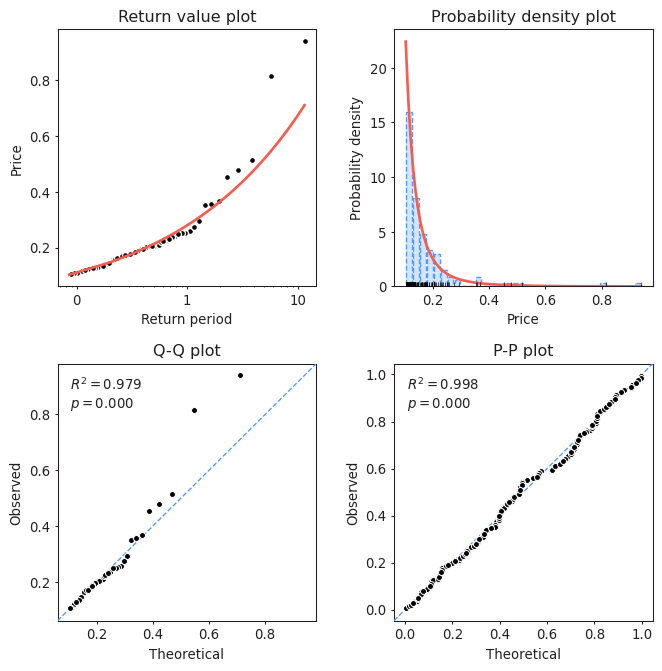

In [120]:
u_static_doge = sorted_static_doge[150]
print(u_static_doge)
params_static_doge = modeling(log_doge_returns, u_static_doge)

### Static EVT-Based VaR and ES Estimation

This step computes **Value at Risk (VaR)** and **Expected Shortfall (ES)** at the **1% level** using the parameters from the static EVT model.



In [121]:
VaR_static_doge, ES_static_doge = prediction(params_static_doge, log_doge_returns, u_static_doge, level=0.01)
print(f"Static EVT 1% VaR: {-VaR_static_doge:.4f}")
print(f"Static EVT 1% ES : {-ES_static_doge:.4f}")


Violation ratio:  0.035842293906810034
Static EVT 1% VaR: 0.1746
Static EVT 1% ES : 0.3057


### Dynamic approach

1. Fit GARCH(1,1) Model
2. Residual standardization
3. Ljung box test (on residuals and squared residuals)
4. ACF plot of squared residuals

Optimization terminated successfully    (Exit mode 0)
            Current function value: -6183.111112392521
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6183.11
Distribution:                  Normal   AIC:                          -12358.2
Method:            Maximum Likelihood   BIC:                          -12332.9
                                        No. Observations:                 4185
Date:                Fri, Jun 06 2025   Df Residuals:                     4184
Time:                        13:55:01   Df Model:                            1
                                  Mean Model                                  
  

/Users/scottyap/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.005614. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


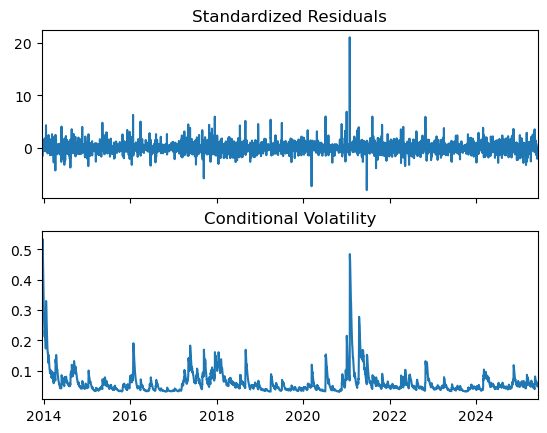

Ljung-Box test on residuals:
    lb_stat  lb_pvalue
1  0.810762   0.367895
Ljung-Box test on squared residuals:
    lb_stat  lb_pvalue
1  0.679725   0.409682
Model is adequate (no remaining ARCH effects).


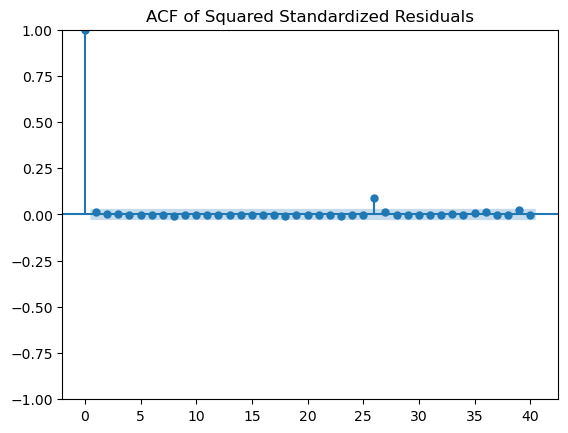

In [122]:
# Two-step process: Fit GARCH(1,1) model, use EVT
doge_model = arch_model(log_doge_returns, vol='Garch', p=1, q=1, mean="Constant") # removed * 10
results = doge_model.fit(update_freq = 5)
print(results.summary())
results.plot()
plt.show()
standardized_resid = results.resid / results.conditional_volatility

# Ljung-Box test (lag 10 as example)
ljung_box = acorr_ljungbox(standardized_resid, lags=1, return_df=True)
print("Ljung-Box test on residuals:")
print(ljung_box)

squared_resid = standardized_resid**2
lb_test_squared = acorr_ljungbox(squared_resid, lags=1, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared)

if lb_test_squared["lb_pvalue"].iloc[0] > 0.05:
    print("Model is adequate (no remaining ARCH effects).")
else:
    print("Model is inadequate (try EGARCH or higher-order GARCH).")

# Step 3: Plot ACF
sm.graphics.tsa.plot_acf(squared_resid, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

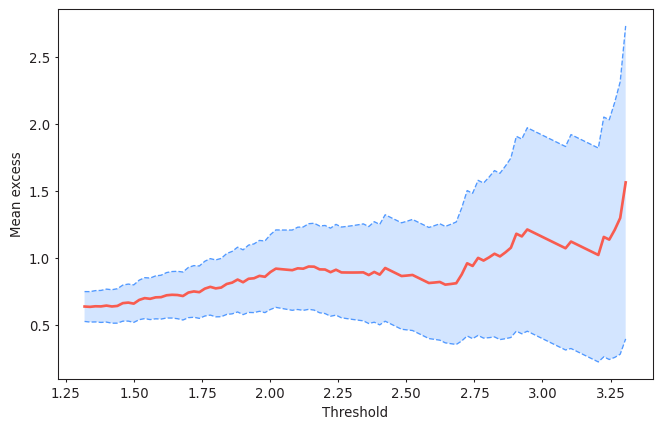

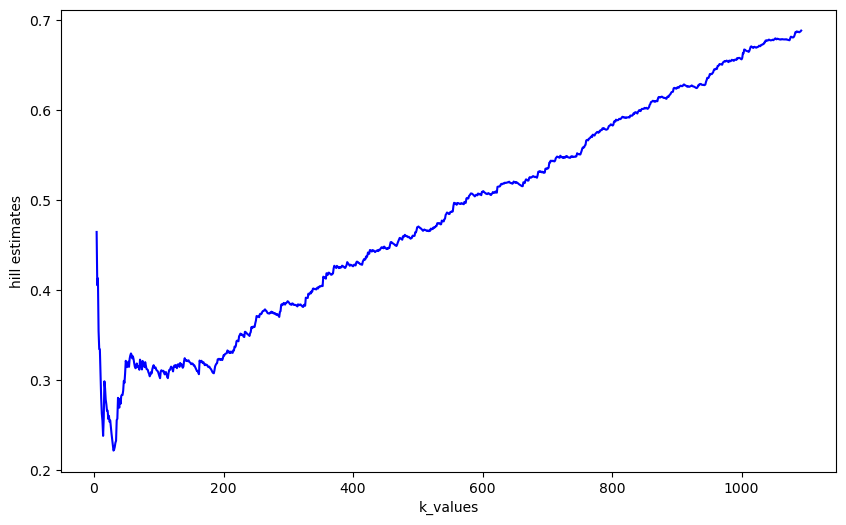

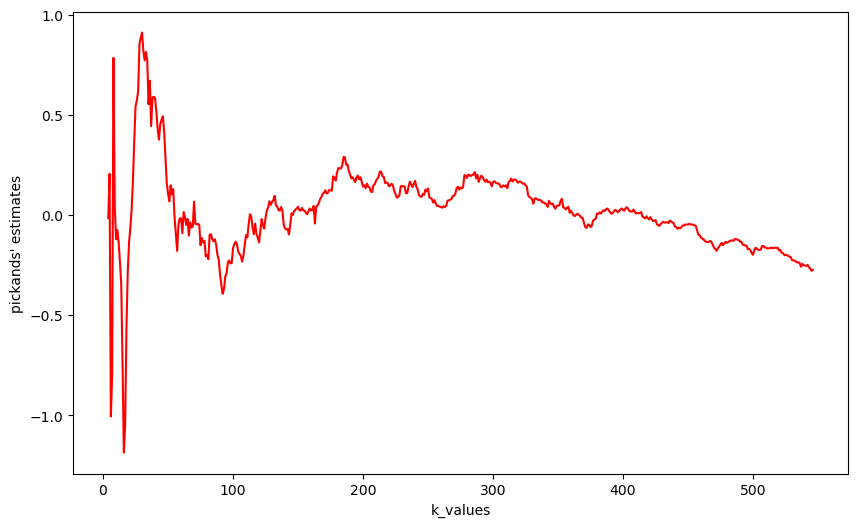

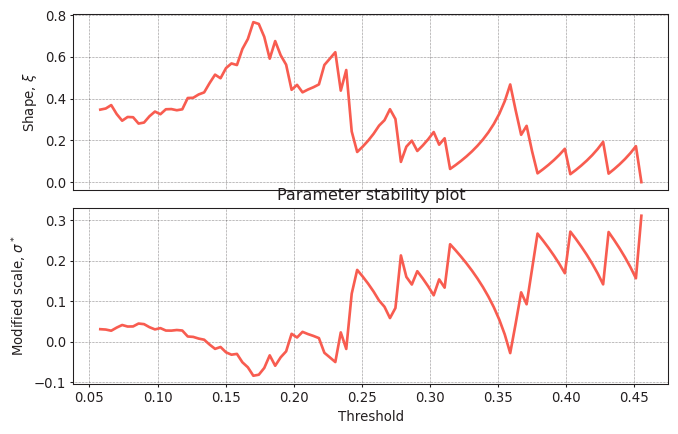

In [123]:
sorted_dynamic_doge = threshold_picking(standardized_resid)

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: ylabel='Modified scale, $\\sigma^*$'>,
 <Axes: ylabel='Return value'>,
 <Axes: xlabel='Threshold', ylabel='AIC Score'>)

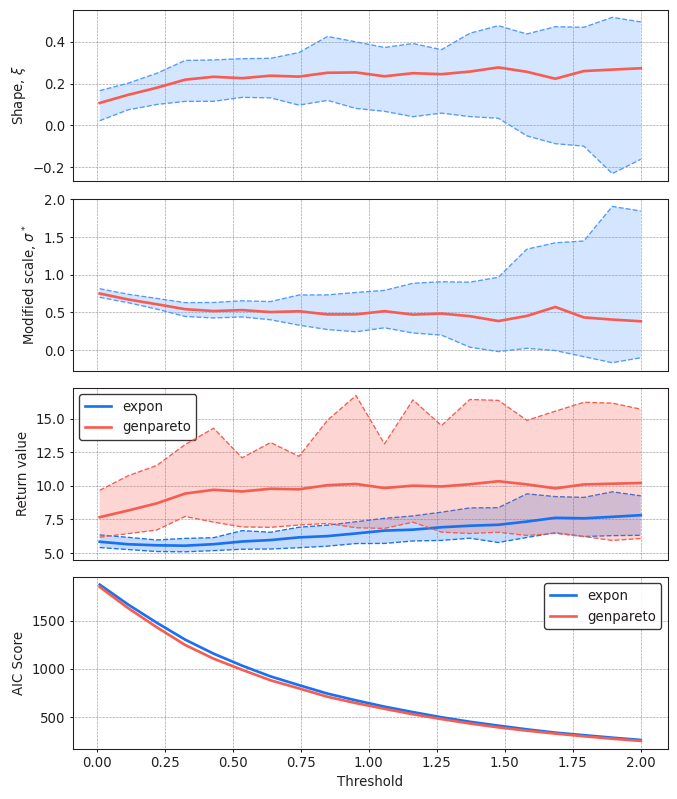

In [124]:
pyx.plot_threshold_stability(standardized_resid, return_period=10, alpha=0.95, thresholds=np.linspace(0.01, 2.0, 20))

threshold for dynamic: 1.370866557421211
              MLE model              
-------------------------------------
free parameters: c=0.218, scale=0.524
fixed parameters: floc=1.371         
AIC: 215.544                         
loglikelihood: -105.739              
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': 0.21807174909138313, 'scale': 0.523872781410774}


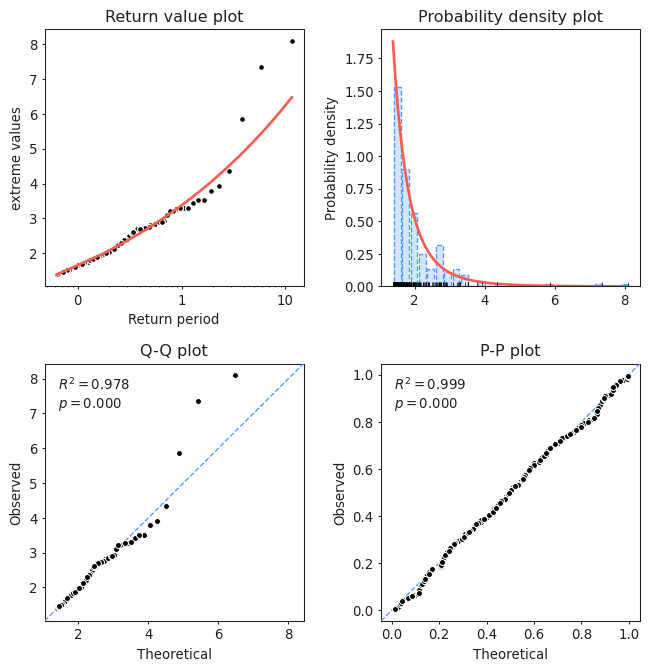

In [127]:
u_dynamic_doge = sorted_dynamic_doge[200]
#u_dynamic_doge = np.searchsorted(sorted_dynamic_doge, 2.25, side="left")
print(f"threshold for dynamic: {u_dynamic_doge}")
params_dynamic_doge = modeling(standardized_resid, u_dynamic_doge)

In [137]:
VaR_dynamic_doge, ES_dynamic_doge = prediction(params_dynamic_doge, standardized_resid, u_dynamic_doge, 0.01)
VaR_return = VaR_dynamic_doge * results.conditional_volatility

# Print selected thresholds
print("\n Thresholds Used:")
print(f"Static EVT Threshold (u_static_doge):  {u_static_doge:.4f}")
print(f"Dynamic EVT Threshold (u_dynamic_doge): {u_dynamic_doge:.4f}")

# Print dynamic EVT results
print("\n Dynamic EVT 1% VaR (on return scale):")
print(VaR_return.describe())

print(f"\n Dynamic EVT 1% Expected Shortfall (ES): {ES_dynamic_doge:.4f}")

# Print static EVT results
print(f"\n Static EVT Results (based on raw log returns):")
print(f"Static EVT 1% VaR: {VaR_static_doge:.4f}")
print(f"Static EVT 1% ES : {ES_static_doge:.4f}")


Violation ratio:  0.04778972520908005

 Thresholds Used:
Static EVT Threshold (u_static_doge):  0.1024
Dynamic EVT Threshold (u_dynamic_doge): 1.3709

 Dynamic EVT 1% VaR (on return scale):
count    4185.000000
mean       -0.147408
std         0.105213
min        -1.254620
25%        -0.158361
50%        -0.117041
75%        -0.096065
max        -0.073799
Name: cond_vol, dtype: float64

 Dynamic EVT 1% Expected Shortfall (ES): -4.3212

 Static EVT Results (based on raw log returns):
Static EVT 1% VaR: -0.1746
Static EVT 1% ES : -0.3057


Unconditional, Conditional coverage test

-2.347430280128123


<Axes: xlabel='Date'>

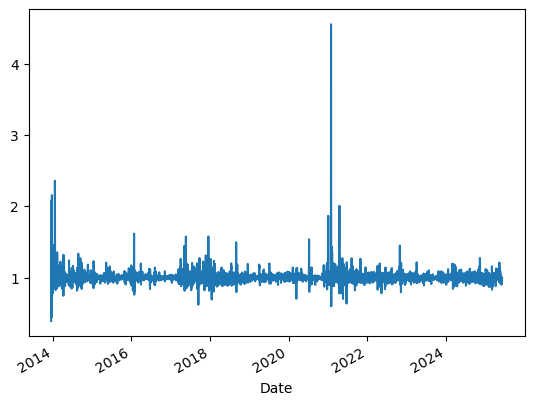

In [140]:
from scipy.stats import chi2

def unconditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    violations = (actual_returns < var_forecast).astype(int) #indicator function
    V = np.sum(violations) # No. of violations
    p = len(actual_returns) # Total observations
    k = V/p

    LR_statistic = -2 * np.log(k**V*(1-k)**(p-V)/(1-alpha)**V*alpha**(p-V))

    p_value = 1 - chi2.cdf(LR_statistic, df=1)

    reject_null = p_value < 0.05

    return LR_statistic, p_value, reject_null

def conditional_coverage_test(actual_returns, var_forecast, alpha=0.05):
    # Unconditional Coverage (UC) Test

    violations = (actual_returns < var_forecast).astype(int) 
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    #print(actual_returns.head(), var_forecast, p_uc)
    LR_uc = -2 * np.log((alpha**V * (1 - alpha)**(n - V))) + 2 * np.log((p_uc**V * (1 - p_uc)**(n - V)))
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

doge_returns = doge_data / doge_data.shift(1).dropna()
doge_returns = doge_returns['Price']
doge_returns.index = pd.to_datetime(doge_returns.index)
converted_VaR_dynamic_doge = np.exp(VaR_dynamic_doge) - 1
print(VaR_dynamic_doge)
doge_returns.plot()

# print(conditional_coverage_test(log_doge_returns, VaR_return, alpha=0.01)) # this should be untouched data, alpha = 0.01
# # VaR dynamic doge is standardized, so we need to convert it back to original scale


In [144]:
# Run conditional coverage tests for dynamic and static models
cc_dynamic = conditional_coverage_test(log_doge_returns, VaR_return, alpha=0.01)
cc_static = conditional_coverage_test(log_doge_returns, np.full_like(log_doge_returns, VaR_static_doge), alpha=0.01)

# Combine both into a DataFrame
cc_table_combined = pd.DataFrame({
    "Statistic": [
        "LR_UC", "p-value_UC", "Reject_UC?",
        "LR_IND", "p-value_IND", "Reject_IND?",
        "LR_CC", "p-value_CC", "Reject_CC?",
        "Violation Rate", "Expected Rate"
    ],
    "Dynamic EVT": [
        cc_dynamic["LR_UC"], cc_dynamic["p-value_UC"], cc_dynamic["Reject_UC?"],
        cc_dynamic["LR_IND"], cc_dynamic["p-value_IND"], cc_dynamic["Reject_IND?"],
        cc_dynamic["LR_CC"], cc_dynamic["p-value_CC"], cc_dynamic["Reject_CC?"],
        cc_dynamic["Violation Rate"], cc_dynamic["Expected Rate"]
    ],
    "Static EVT": [
        cc_static["LR_UC"], cc_static["p-value_UC"], cc_static["Reject_UC?"],
        cc_static["LR_IND"], cc_static["p-value_IND"], cc_static["Reject_IND?"],
        cc_static["LR_CC"], cc_static["p-value_CC"], cc_static["Reject_CC?"],
        cc_static["Violation Rate"], cc_static["Expected Rate"]
    ]
})

# Display as a clean comparison table
display(cc_table_combined)


,Statistic,Dynamic EVT,Static EVT
0,LR_UC,0.000542,0.083839
1,p-value_UC,0.981419,0.772161
2,Reject_UC?,False,False
3,LR_IND,0.586828,0.752816
4,p-value_IND,0.443648,0.385586
5,Reject_IND?,False,False
6,LR_CC,0.587371,0.836655
7,p-value_CC,0.745511,0.658147
8,Reject_CC?,False,False
9,Violation Rate,0.010036,0.009558


Both models pass the backtests — they do not violate unconditional, independence, or conditional coverage assumptions at the 1% level.
However, the Dynamic EVT model performs better statistically and practically.

Why Dynamic EVT is Better
Closer match to violation rate (1.0036% vs. 0.9558%)

Higher p-values across all tests (i.e., stronger evidence of model adequacy)

Smaller likelihood ratios, indicating better model fit

Incorporates time-varying volatility via GARCH, making it more adaptive to market conditions

This tells you how often you expect certain extreme returns to happen, based on your model. 

In [143]:
print(f"stand_resid: {standardized_resid}")

extremes = pyx.get_extremes(
    ts=standardized_resid,
    method="POT",
    threshold = 0.12
)
return_periods = pyx.get_return_periods(
    ts=standardized_resid,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    return_period_size="365.2425D",
    plotting_position="weibull",
)
return_periods.sort_values("return period", ascending=False).head()

stand_resid: Date
2013-12-17   -2.274278
2013-12-18    0.419253
2013-12-19    1.238411
2013-12-20    1.556782
2013-12-21   -1.631763
                ...   
2025-05-31   -0.073289
2025-06-01    0.101687
2025-06-02    0.173631
2025-06-03   -0.223444
2025-06-04   -0.182704
Length: 4185, dtype: float64


,extreme values,exceedance probability,return period
Date,,,
2021-01-28,21.111255,0.000954,11.474566
2021-01-02,6.878181,0.001908,5.737283
2016-01-26,6.272264,0.002863,3.824855
2020-07-08,5.972607,0.003817,2.868641
2021-08-07,5.946871,0.004771,2.294913
